# Time series forecasting

This notebook is derived from https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network, and reduced to a muti-step prediction for the persons at the market place.

##### Copyright 2019 The TensorFlow Authors.
##### Copytight 2022 Ralf Lüben

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Install required libraries, load libraries, and set default matplot parameters.

In [2]:
!pip install tensorflow==2.10
!pip install matplotlib
!pip install pandas
!pip install seaborn
import os
import datetime 
from distutils.util import strtobool
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import csv
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

     |█████████████████               | 308.6 MB 202.2 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 578.1 MB 21 kB/s /s eta 0:00:01
     |████████████████████████████████| 126 kB 85.6 MB/s eta 0:00:01
     |████████████████████████████████| 5.9 MB 56.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 65.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 67.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.9 MB 66.3 MB/s eta 0:00:01
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.11.0
    Uninstalling absl-py-0.11.0:
      Successfully uninstalled absl-py-0.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully unin

## The dataset

The data is loaded from the previous concatenated dataset. New fields are added that contain the month, the weekday, the hour, the day and year of the measurements. The timestamp is used as index.

Since timestamps are collected irregulary, the dataset is resampled to a 1h interval, all samples in the interval are aggregated by the mean.

In [3]:
dateparse = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
df = pd.read_csv("persons.csv", dtype = {'value': float}, parse_dates=[0], date_parser=dateparse,)

df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year

df.set_index('timestamp', inplace=True)
df=df.resample("1h", origin="2021-01-01").mean()
df=df.fillna(0)

To evaluate different network architectures and also input features, we define to ENV variabes to set and control the training. Later these can be used in the pipeline.

In [4]:
ENV_NA=os.environ.get('KF_NA', "Dense")
ENV_FR=strtobool(os.environ.get('KF_FREQ',"true"))

allowed_NA = ["Conv", "Dense", "Linear", "LSTM"]
if ENV_NA not in allowed_NA:
    print("NA must be one of", allowed_NA)
    quit()

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [5]:
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)
print(timestamp_s)

Float64Index([1609462800.0, 1609466400.0, 1609470000.0, 1609473600.0,
              1609477200.0, 1609480800.0, 1609484400.0, 1609488000.0,
              1609491600.0, 1609495200.0,
              ...
              1672498800.0, 1672502400.0, 1672506000.0, 1672509600.0,
              1672513200.0, 1672516800.0, 1672520400.0, 1672524000.0,
              1672527600.0, 1672531200.0],
             dtype='float64', name='timestamp', length=17520)


Person day has clearly daily, weekly, and year periodicity. Therefore we make easily explorable by the NN by using sine and cosine transforms:

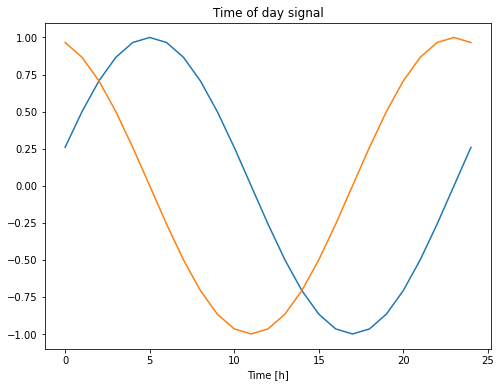

In [6]:
if ENV_FR==True:
    day = 24*60*60
    week = 7*day
    year = (365)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    plt.plot(np.array(df['Day sin'])[:25])
    plt.plot(np.array(df['Day cos'])[:25])
    plt.xlabel('Time [h]')
    plt.title('Time of day signal')

### Split the data

We use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.7):int(n*9)]
test_df = df[int(n*0.1):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models).

This section focuses on implementing the data windowing so that it can be reused for all of those models.


The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot and evaluate

Here is a plot method that allows a simple visualization of the split window, for the prediction values below zero are clipped to zero, since no negative number of persons can appear:

In [11]:
def plot(self, model=None, plot_col='value', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    #plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    #         label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    plt.scatter(self.label_indices, labels[n, :, label_col_index]*train_std[plot_col_index]+train_mean[plot_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      y_pred = predictions[n, :, label_col_index]*train_std[plot_col_index]+train_mean[plot_col_index]
      y_pred_max = tf.math.reduce_max(y_pred)
      # We can clip by zero, since no negative number of persons can be at the market place.
      y_pred = tf.clip_by_value(y_pred,0,y_pred_max)
      plt.scatter(self.label_indices, y_pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [12]:
def evaluate(self, model=None, plot_col='value', max_subplots=3):
  inputs, labels = self.example
  #plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  label_col_index = plot_col_index
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    y_true = labels[n, :, label_col_index]*train_std[plot_col_index]+train_mean[plot_col_index]
    predictions = model(inputs)
    y_pred = predictions[n, :, label_col_index]*train_std[plot_col_index]+train_mean[plot_col_index]
    y_pred = tf.clip_by_value(y_pred,0,100000)
    print(tf.keras.metrics.mean_absolute_error(y_true,y_pred))

WindowGenerator.eval = evaluate

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [15]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## Multi-step models

In a multi-step prediction, the model needs to learn to predict a range of future values.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict one week into the future, given 30 days of the past.

Here is a `Window` object that generates these slices from the dataset:

In [16]:
OUT_STEPS = 24*7
IN_STEPS = 24*30*1
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=["value"])
multi_val_performance = {}
multi_performance = {}

#### Linear
The first model is a simple linear regression.

In [17]:
if ENV_NA=="Linear":
    model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(model, multi_window)

    IPython.display.clear_output()
    multi_val_performance['Linear'] = model.evaluate(multi_window.val)
    multi_performance['Linear'] = model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(model)
    np.save("perf.npy", [multi_val_performance['Linear'], multi_performance['Linear']])

#### Dense

Adding more `tf.keras.layers.Dense` between the input and output gives the linear model more power, furthermore all timesteps are considered for prediction by flatten the input.

Epoch 1/50
301/301 [==============================] - 156s 514ms/step - loss: 0.6180 - mean_absolute_error: 0.3592 - val_loss: 0.8276 - val_mean_absolute_error: 0.4170
Epoch 2/50
301/301 [==============================] - 151s 500ms/step - loss: 0.4280 - mean_absolute_error: 0.2986 - val_loss: 0.7431 - val_mean_absolute_error: 0.3830
Epoch 3/50
301/301 [==============================] - 149s 495ms/step - loss: 0.3464 - mean_absolute_error: 0.2714 - val_loss: 0.7198 - val_mean_absolute_error: 0.3551
Epoch 4/50
301/301 [==============================] - 147s 488ms/step - loss: 0.3160 - mean_absolute_error: 0.2565 - val_loss: 0.6337 - val_mean_absolute_error: 0.3585
Epoch 5/50
301/301 [==============================] - 151s 499ms/step - loss: 0.2725 - mean_absolute_error: 0.2403 - val_loss: 0.5844 - val_mean_absolute_error: 0.3294
Epoch 6/50
301/301 [==============================] - 151s 502ms/step - loss: 0.2315 - mean_absolute_error: 0.2251 - val_loss: 0.5967 - val_mean_absolute_error:

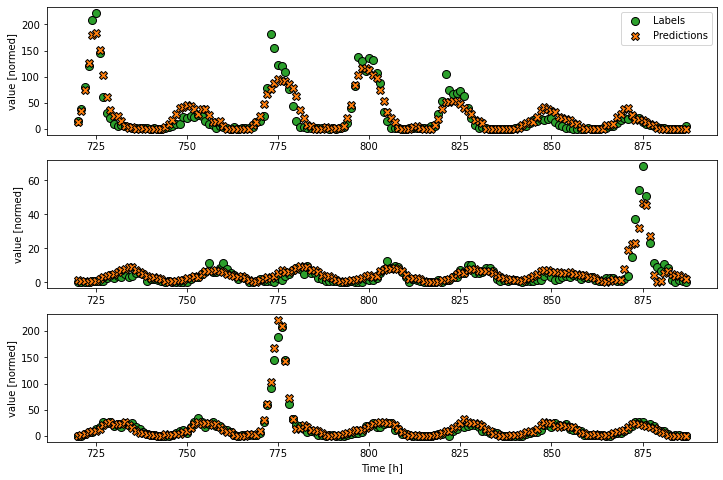

In [18]:
if ENV_NA=="Dense":
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(IN_STEPS*3, activation='relu'),
        tf.keras.layers.Dense(IN_STEPS, activation='relu'),
        tf.keras.layers.Dense(OUT_STEPS*num_features*3, activation='relu'),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(model, multi_window)
    multi_window.plot(model)
    multi_val_performance['Dense'] = model.evaluate(multi_window.val)
    multi_performance['Dense'] = model.evaluate(multi_window.test, verbose=0)
    np.save("perf.npy", [multi_val_performance['Dense'], multi_performance['Dense']])

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

In [ ]:
if ENV_NA=="Conv":
    CONV_WIDTH = IN_STEPS
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1,  out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['Conv'] = model.evaluate(multi_window.val)
    multi_performance['Conv'] = model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(model)
    np.save("perf.npy", [multi_val_performance['Conv'], multi_performance['Conv']])

In [ ]:
#multi_window.eval(multi_conv_model, max_subplots=100)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making.

In [ ]:
if ENV_NA=="LSTM":
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    history = compile_and_fit(model, multi_window)

    IPython.display.clear_output()

    multi_val_performance['LSTM'] = model.evaluate(multi_window.val)
    multi_performance['LSTM'] = model.evaluate(multi_window.test, verbose=0)
    multi_window.plot(model)
    np.save("perf.npy", [multi_val_performance['LSTM'], multi_performance['LSTM']])

### Performance

To visualize the results, we write the performance in `mlpipeline-ui-metadata.json` to make it accessible for visualization in the kubeflow pipeline.

In [ ]:
results = [ multi_val_performance[ENV_NA][1]*train_std[0]+train_mean[0], multi_performance[ENV_NA][1]*train_std[0]+train_mean[0]]

metadata = {
    'outputs' :  [{
      'type': 'table',
      'storage': 'inline',
      'format': 'csv',
      'header': ["val", "test"],
      'source': ','.join(str(x) for x in results)
    }]
}

with open("mlpipeline-ui-metadata.json", "w", encoding="utf-8") as metadata_file:
    json.dump(metadata, metadata_file)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index]*train_std[0]+train_mean[0] for v in multi_val_performance.values()]
test_mae = [v[metric_index]*train_std[0]+train_mean[0] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.